In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Imports
import numpy as np
import sys
from os import makedirs
from os.path import join
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from persim import PersistenceImager

rng_seed = 399
np.random.seed(rng_seed)

sys.path.append("..")

from gudhi import plot_persistence_diagram
from gudhi.rips_complex import RipsComplex
from vis_utils import configure_plotting_for_thesis

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

In [3]:
# Constants
output_dir = "output_plots"
makedirs(output_dir, exist_ok=True)
save_plots_to_file = True

<IPython.core.display.Javascript object>

## Persistence diagram

In [4]:
# Create data
pd_data = np.row_stack(
    [
        make_blobs(
            n_samples=10, cluster_std=0.75, center_box=(2, 2), random_state=rng_seed
        )[0],
        make_blobs(
            n_samples=10,
            cluster_std=0.75,
            center_box=(-2, -2),
            random_state=rng_seed + 1,
        )[0],
    ]
)
alpha_levels = [0.2, 1.5, 4.5]

<IPython.core.display.Javascript object>

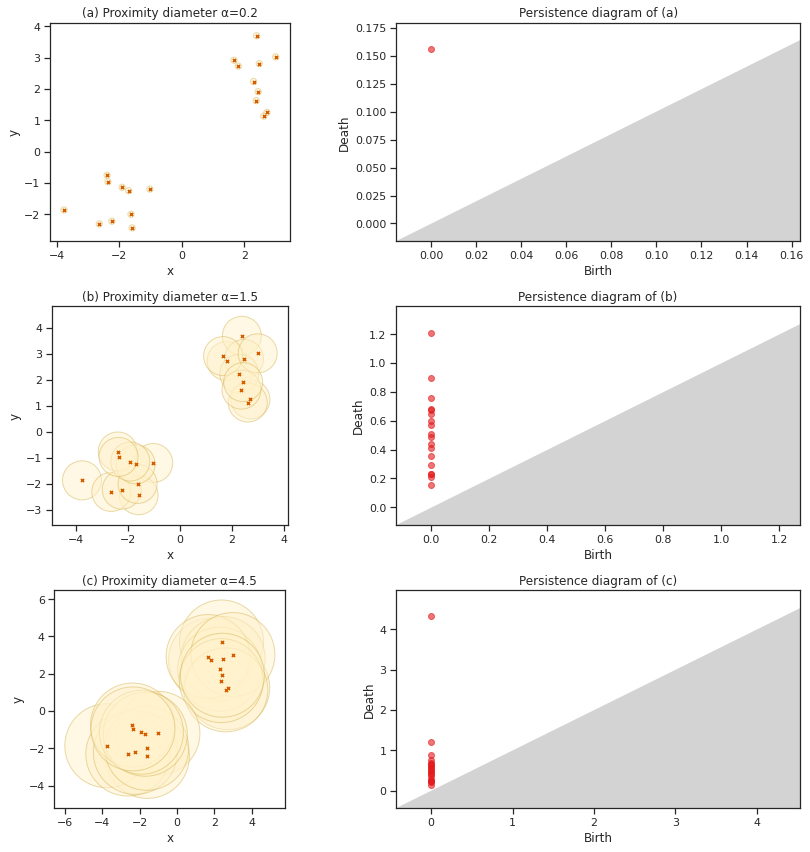

<IPython.core.display.Javascript object>

In [14]:
# Create persistence diagram data
rips_complex = RipsComplex(pd_data)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
barcodes = simplex_tree.persistence()

# Plot example
plot_chars = "abc"
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6 * 2, 4 * 3))
for alpha_level, plot_char, (ax1, ax2) in zip(alpha_levels, plot_chars, axes):

    # Plot data points
    ax1.set_aspect("equal", adjustable="box")
    for i in range(len(pd_data)):
        ax1.add_patch(
            plt.Circle(
                xy=tuple(pd_data[i]),
                radius=alpha_level / 2,
                alpha=0.5,
                facecolor="#fff2cc",
                edgecolor="#d6b656",
            )
        )
    ax1.scatter(pd_data[:, 0], pd_data[:, 1], s=10, c="r", marker="x", zorder=100)
    ax1.set_title(f"({plot_char}) Proximity diameter α={alpha_level}")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    # Plot PD
    plot_persistence_diagram(
        [
            (dim, (birth, death))
            for dim, (birth, death) in barcodes
            if death <= alpha_level
        ],
        axes=ax2,
        fontsize=12,
    )
    ax2.set_title(f"Persistence diagram of ({plot_char})")

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "persistence-diagram-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Persistence image

In [10]:
# Prepare data
pi_data_X, _ = make_circles(
    n_samples=200, noise=0.05, random_state=rng_seed, factor=0.5
)
pi_data_rips_complex = RipsComplex(pi_data_X)
pi_data_simplex_tree = pi_data_rips_complex.create_simplex_tree(max_dimension=2)
pi_data_barcodes = pi_data_simplex_tree.persistence()

<IPython.core.display.Javascript object>

In [11]:
def create_barcodes_dict(barcodes: list) -> dict:
    """
    Creates barcodes dictionary from list.

    Parameters
    ----------
    barcodes : list
        List of PD barcodes.

    Returns
    -------
    barcodes_dict : dict
        Dictionary with homology dimension as key and list of
        birth-death coordinates as values.
    """
    barcodes_dict = {}
    for dim, (birth, death) in barcodes:
        if death == np.inf:
            continue
        if dim not in barcodes_dict:
            barcodes_dict[dim] = []
        barcodes_dict[dim].append([birth, death])
    for dim, birth_death_points in barcodes_dict.items():
        barcodes_dict[dim] = np.array(birth_death_points)
    return barcodes_dict

<IPython.core.display.Javascript object>

Persistence image size: width=66, height=35


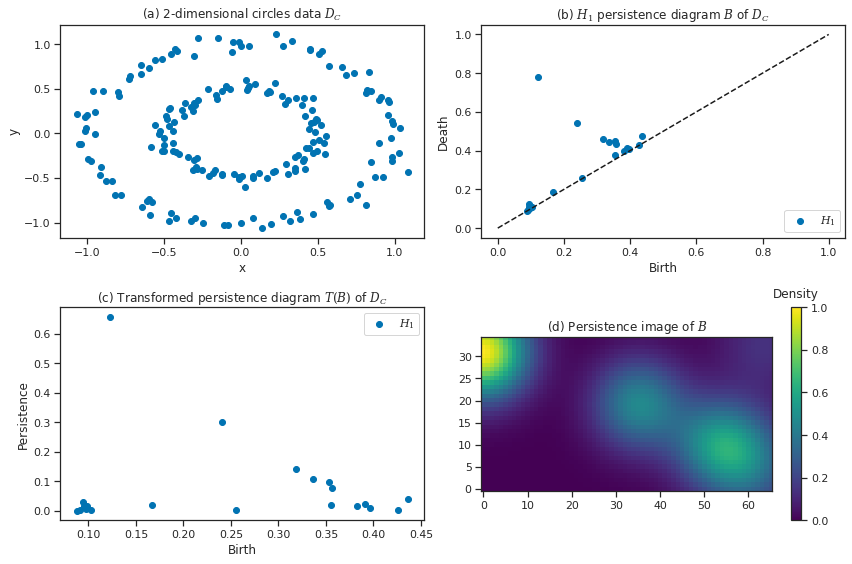

<IPython.core.display.Javascript object>

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax1.scatter(pi_data_X[:, 0], pi_data_X[:, 1])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title(r"(a) 2-dimensional circles data $D_C$")

pi_data_barcodes_dict = create_barcodes_dict(pi_data_barcodes)
birth_death_points = pi_data_barcodes_dict[1]
ax2.scatter(x=birth_death_points[:, 0], y=birth_death_points[:, 1], label=r"$H_1$")
ax2.plot([0, 1], [0, 1], "k--")
ax2.set_xlabel("Birth")
ax2.set_ylabel("Death")
ax2.legend(loc="lower right")
ax2.set_title(r"(b) $H_1$ persistence diagram $B$ of $D_C$")

ax3.scatter(
    x=birth_death_points[:, 0],
    y=birth_death_points[:, 1] - birth_death_points[:, 0],
    label=r"$H_1$",
)
ax3.set_xlabel("Birth")
ax3.set_ylabel("Persistence")
ax3.legend()
ax3.set_title(r"(c) Transformed persistence diagram $T(B)$ of $D_C$")

pimgr = PersistenceImager(
    pixel_size=0.01, kernel_params={"sigma": [[0.005, 0], [0, 0.005]]}
)
pi_data_pimg = np.array(pimgr.fit_transform(pi_data_barcodes_dict[1]))
pimgr_handle = ax4.imshow(
    X=np.flipud(np.fliplr(pi_data_pimg / pi_data_pimg.max())),
    interpolation="none",
    origin="lower",
    cmap="viridis",
    vmin=0,
    vmax=1,
)
# ax4.set_yticks([])
# ax4.set_xticks([])
ax4.set_title(r"(d) Persistence image of $B$")
ax4_clb = fig.colorbar(pimgr_handle)
ax4_clb.ax.set_title("Density", pad=10)
print(
    f"Persistence image size: width={pi_data_pimg.shape[1]}, height={pi_data_pimg.shape[0]}"
)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "persistence-image-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()